## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# # performs the camera calibration, image distortion correction and 
# # returns the undistorted image
# def cal_undistort(img, objpoints, imgpoints):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
#     gray.shape[::-1], None, None)
#     undist = cv2.undistort(img, mtx, dist, None, mtx)  
#     return undist

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)        
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    #print(idx)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


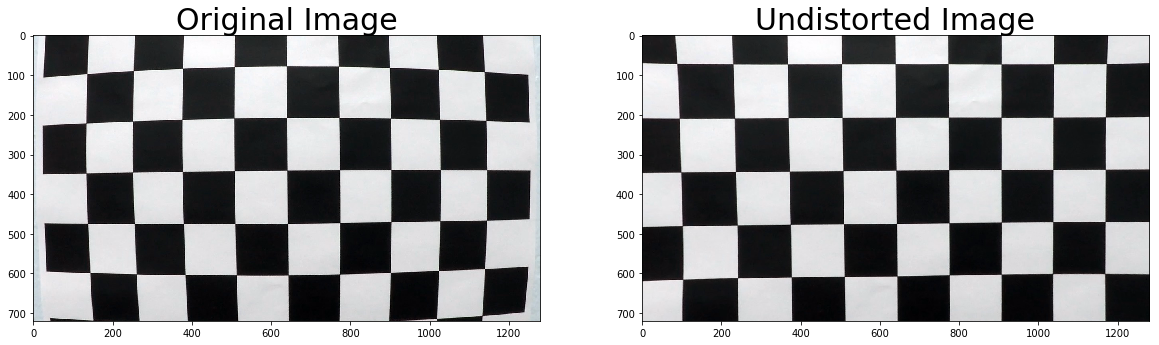

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('../camera_cal/test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

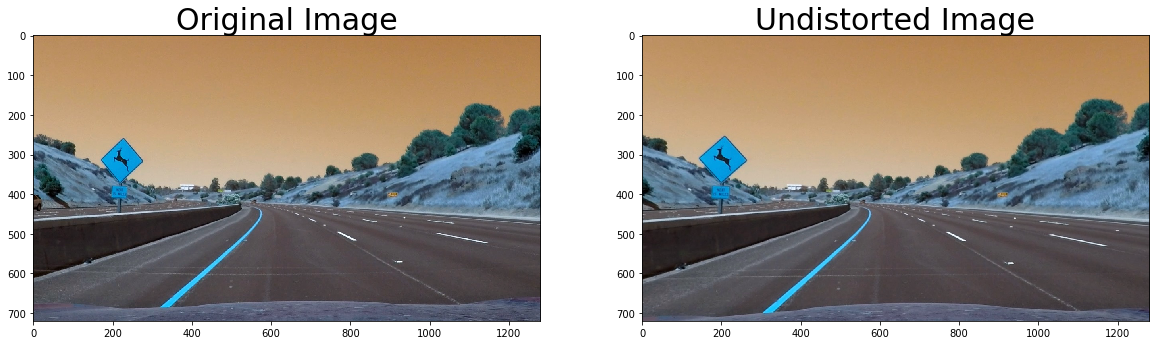

In [27]:
# Test undistortion on a road image
img = cv2.imread('test_images/test2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

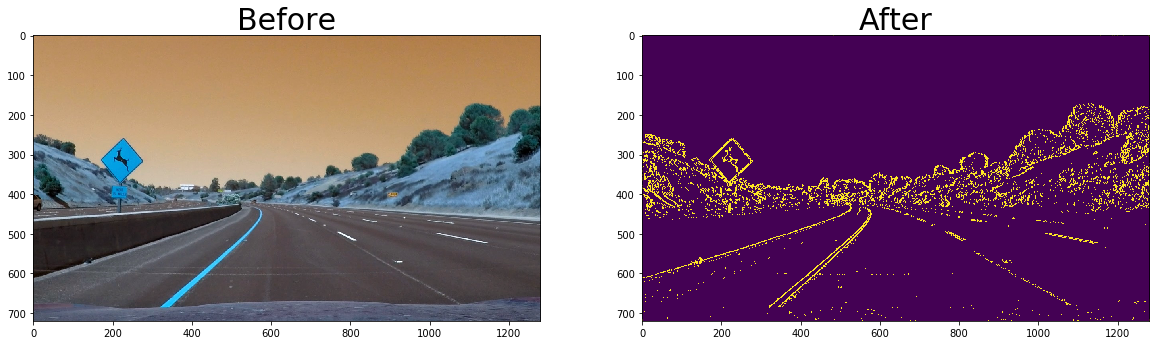

In [13]:
#Construct Binary Image

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = []
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary  # binary_output

img = cv2.imread('test_images/test2.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Before', fontsize=30)
ax2.imshow(abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=120))
ax2.set_title('After', fontsize=30)

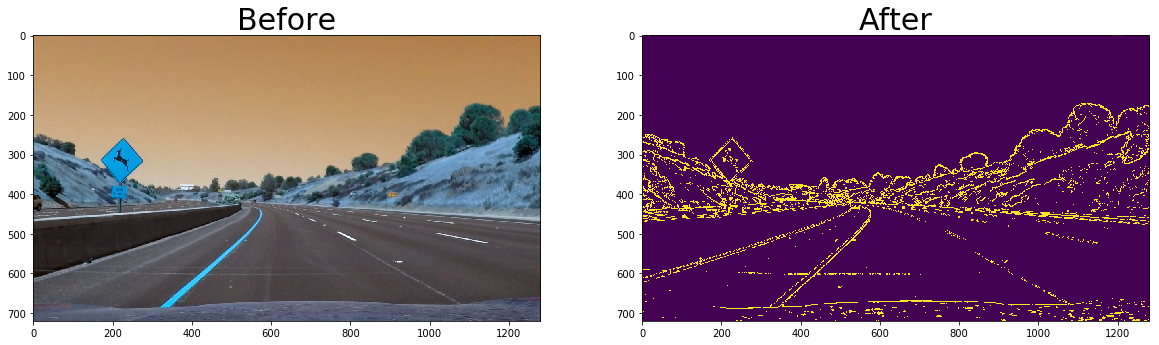

In [22]:
# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * magnitude / np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1  
    return binary_output

img = cv2.imread('test_images/test2.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Before', fontsize=30)
ax2.imshow(mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)))
ax2.set_title('After', fontsize=30)

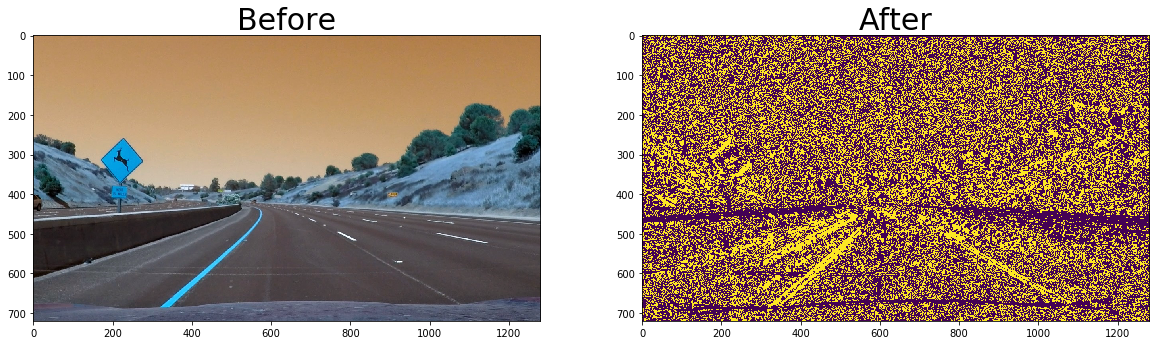

In [26]:
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobel_x)
    abs_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_gra = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gra)
    # 6) Return this mask as your binary_output image
    binary_output[(dir_gra >= thresh[0]) & (dir_gra <= thresh[1])] = 1
    return binary_output

img = cv2.imread('test_images/test2.jpg')
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Before', fontsize=30)
ax2.imshow(dir_binary)
ax2.set_title('After', fontsize=30)

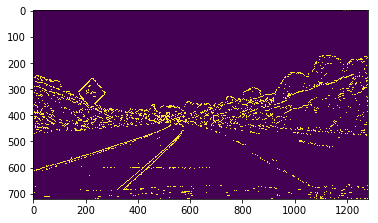

In [40]:
# Choose a Sobel kernel size
ksize = 5  # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=120)
grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=150)
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined)

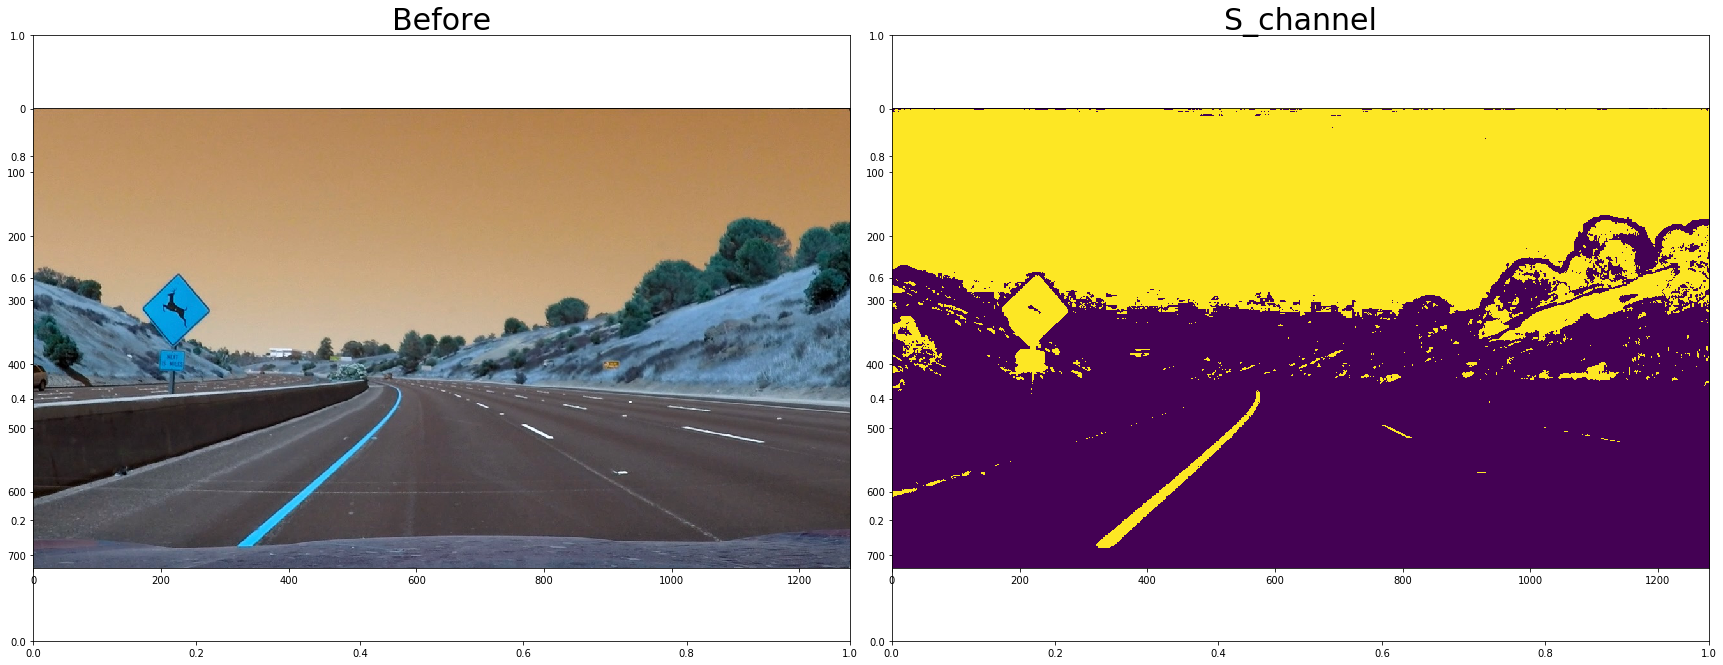

In [59]:
# HLS
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary_s = np.zeros_like(S)
binary_s[(S > thresh[0]) & (S <= thresh[1])] = 1

thresh = (15, 100)
binary_h = np.zeros_like(H)
binary_h[(H > thresh[0]) & (H <= thresh[1])] = 1

R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
thresh = (150, 255)
binary_r = np.zeros_like(R)
binary_r[(R > thresh[0]) & (R <= thresh[1])] = 1

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('S_channel', fontsize=30)
plt.imshow(binary_s)


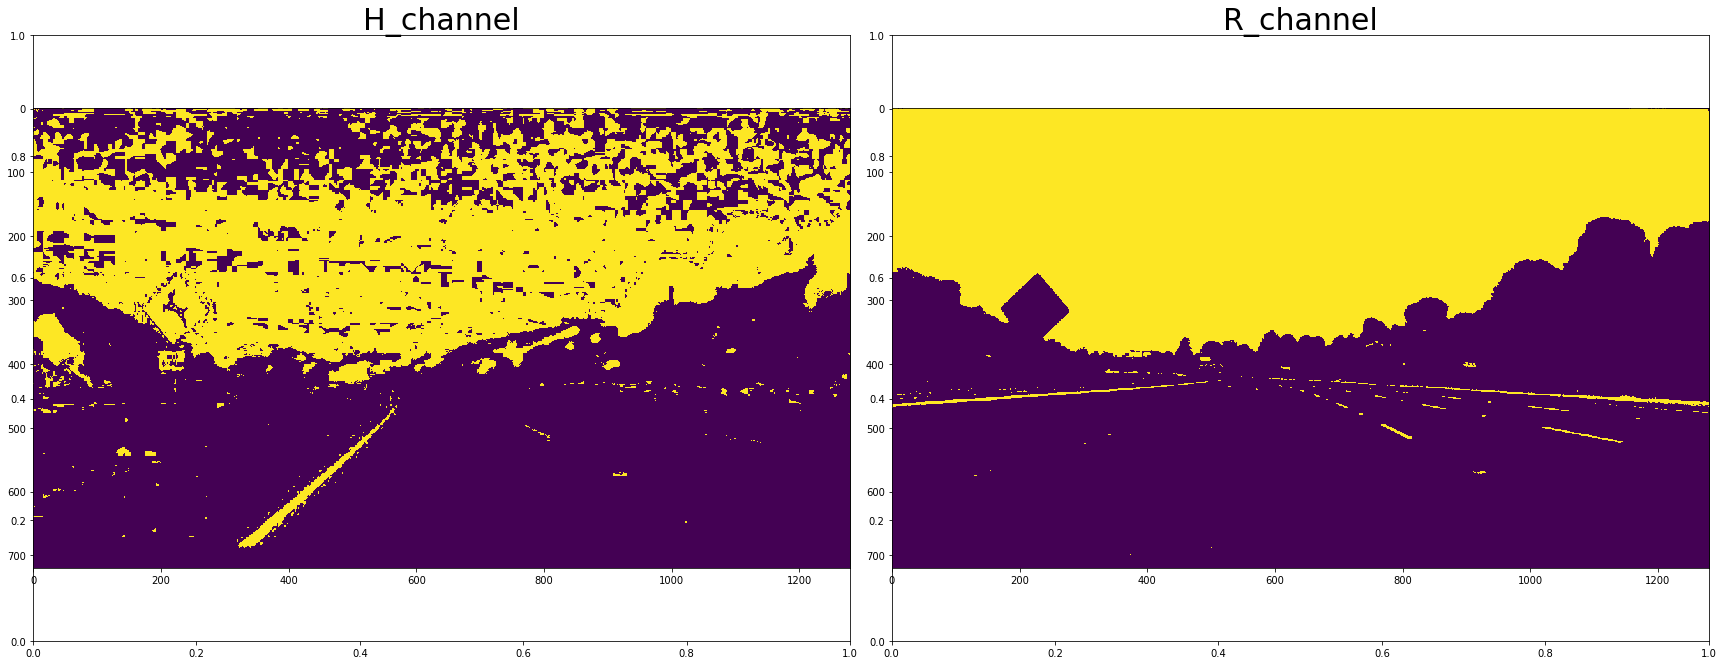

In [60]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
fig.add_subplot(1,2,1)
ax1.set_title('H_channel', fontsize=30)
plt.imshow(binary_h)
fig.add_subplot(1,2,2)
ax2.set_title('R_channel', fontsize=30)
plt.imshow(binary_r)

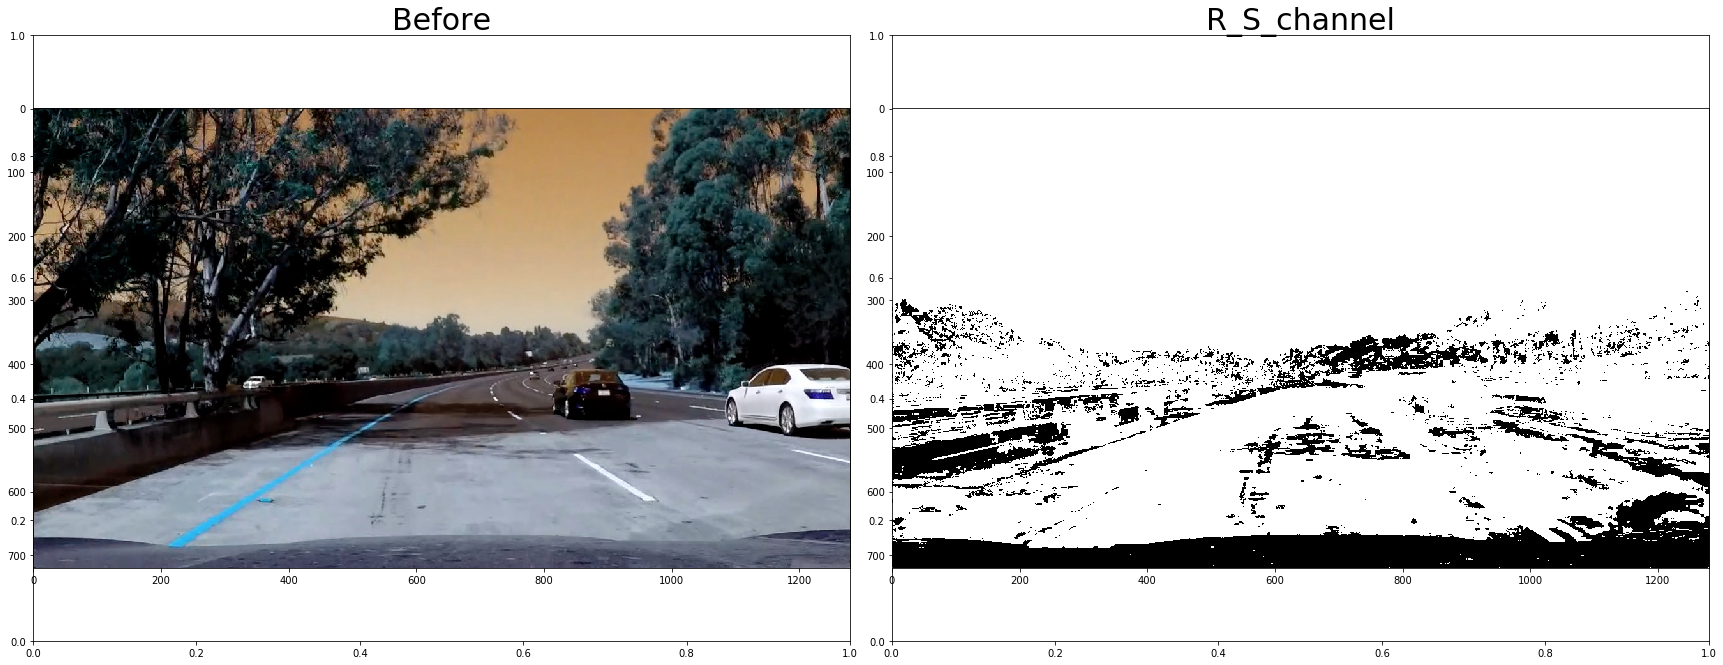

In [89]:
# Combine R and S channel
def r_s_chanel(img, thresh_r = (200, 255), thresh_s=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= thresh_s[0]) & (S <= thresh_s[1])] = 1
    
    R = img[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R >= thresh_r[0]) & (R <= thresh_r[1])] = 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    
    binary_rs[((R > thresh_r[0]) & (R <= thresh_r[1]))
              | ((S > thresh_s[0]) & (S <= thresh_s[1]))] = 1
    return binary_rs
    
img = cv2.imread('test_images/test5.jpg')

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('R_S_channel', fontsize=30)
plt.imshow(r_s_chanel(img, thresh_r, thresh_s), cmap='gray')


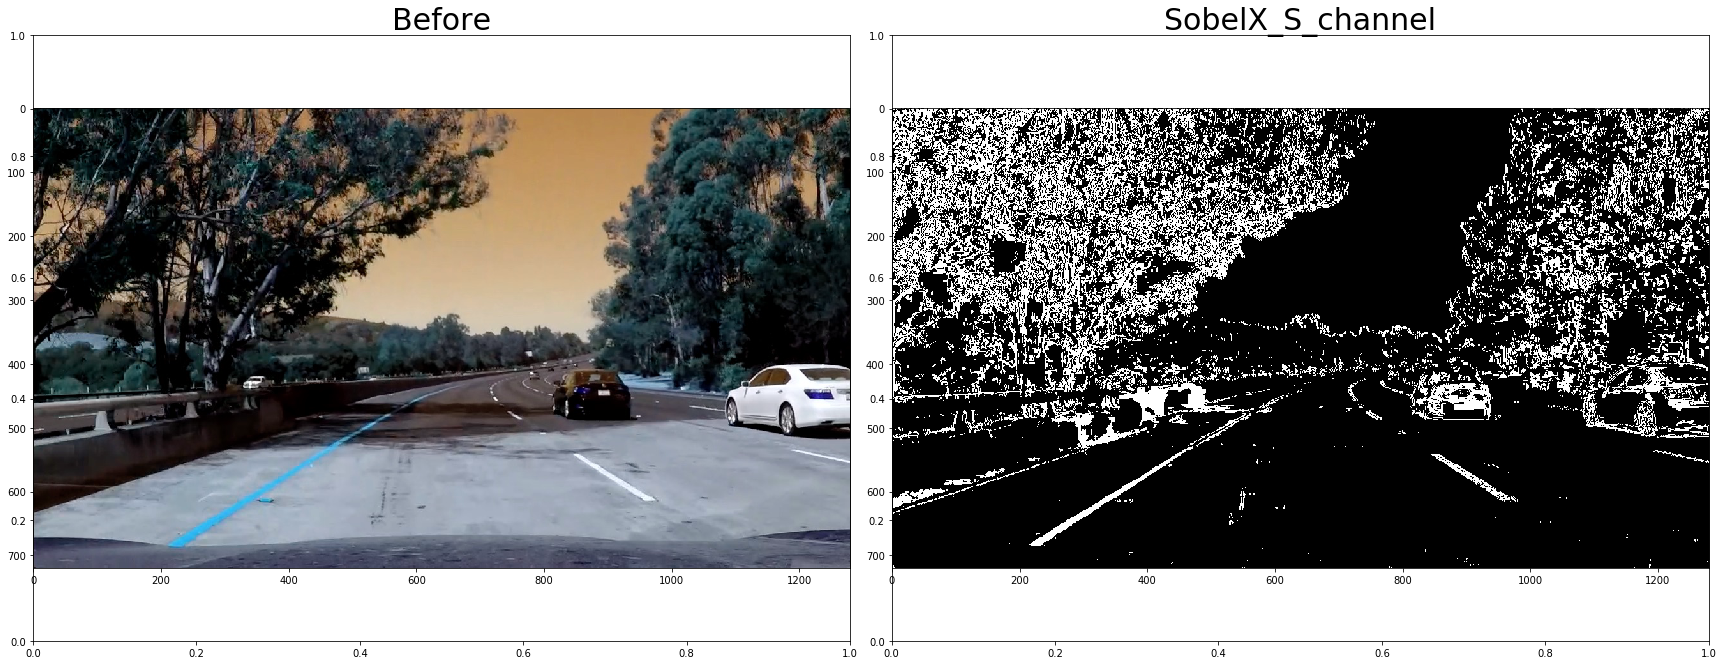

In [90]:
# Combine SobelX and S channel
def sobelx_s_chanel(img, thresh_sobel=(20,100), thresh_s=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= thresh_s[0]) & (S <= thresh_s[1])] = 1
    
#     R = img[:,:,0]
#     r_binary = np.zeros_like(R)
#     r_binary[(R >= thresh_r[0]) & (R <= thresh_r[1])] = 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_sobel[0]) & (scaled_sobel <= thresh_sobel[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
#     binary_rs[((R > thresh_r[0]) & (R <= thresh_r[1]))
#               | ((S > thresh_s[0]) & (S <= thresh_s[1]))] = 1
#     return binary_rs
#     thresh_r = (200, 255)
#     thresh_s = (175, 255)
#     binary_rs = np.zeros_like(R)
#     binary_rs[(R > thresh_r[0]) & (R <= thresh_r[1]) & (S > thresh_s[0]) & (S <= thresh_s[1])] = 1
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

fig.add_subplot(1,2,1)
ax1.set_title('Before', fontsize=30)
plt.imshow(img)
fig.add_subplot(1,2,2)
ax2.set_title('SobelX_S_channel', fontsize=30)
plt.imshow(sobelx_s_chanel(img, thresh_sobel=(20,100), thresh_s=(170,255)),cmap='gray')



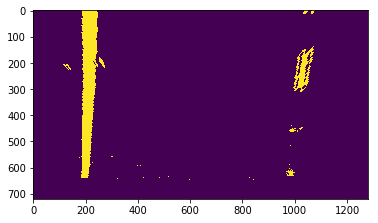

In [112]:
# Warp transform
def unwarp(img):
    length = gray.shape[1]
    width = gray.shape[0]
    top_left = [550,480]
    top_right = [720,480]
    bottom_left = [315,645]
    bottom_right = [1000,645]
    src =  np.float32([top_left, bottom_left, top_right, bottom_right])
    dst = np.float32([[200, 50], [200, 600], [1000, 50],  [1000, 600]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    size = (gray.shape[1], gray.shape[0])
    warped = cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)
    return warped, Minv

img = plt.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img = sobelx_s_chanel(img)
dst,Minv = unwarp(img)
plt.imshow(dst)

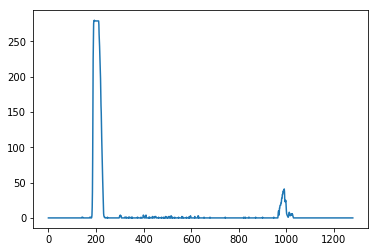

In [113]:
# Histogram
histogram = np.sum(dst[int(dst.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [118]:
# Detect lane via sliding window

def find_lane(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    binary_warped, Minv = unwarp(img)
    histogram = np.sum(dst[int(binary_warped.shape[0]/2):,:], axis=0)    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualization
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

combined_img = sobelx_s_chanel(img, thresh_sobel=(20,100), thresh_s=(170,255))
find_lane(combined_img)


error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7646: error: (-215) (scn == 3 || scn == 4) && (depth == CV_8U || depth == CV_32F) in function ipp_cvtColor
